In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
params = {'text.latex.preamble' : [r'\usepackage{siunitx}', r'\usepackage{amsmath}']}
plt.rcParams.update(params)

/Users/jacob/opt/anaconda3/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [285]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from bayes_opt import BayesianOptimization, UtilityFunction
from sklearn.metrics import plot_roc_curve, roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import shap
import joblib
import os
import statsmodels.api as sm
import numpy as np

In [4]:
# !conda install -c conda-forge xgboost -y

In [5]:
# !conda install -c conda-forge shap -y

In [6]:
# !conda install -c conda-forge bayesian-optimization -y

In [306]:
#base model
model_df = pd.read_csv('dataset_without_rep.csv')

#HC model
model_hc = pd.read_csv('model_df_HC_final.csv')

#Big 5 model
model_bf = pd.read_csv('dataset_with_rep.csv')
bf_drop = ['achievement', 'active', 'adventurous', 'affiliation', 'aggressive', 
           'ambitious', 'anxiety_prone', 'artistic', 'assertive', 
           'authentic', 'cautious', 'cheerful', 'clout', 'cooperative', 
           'disciplined', 'dutiful', 'emotionally_aware', 'empathetic', 'energetic', 
           'friendly', 'generous', 'genuine', 'humble', 'imaginative', 'impulsive', 'intellectual', 
           'inward_focus', 'liberal', 'melancholy', 'negations','organized', 
           'outward_focus', 'power', 'reward', 'risk_aversion', 'risk_seeking', 'self_assured', 'self_conscious', 
           'sociable', 'social', 'stress_prone', 'trusting']
model_bf.drop(columns = bf_drop, inplace=True)

#Big 5 model + HC
cols_to_use = model_bf.columns.difference(model_hc.columns)
model_bf_hc = pd.merge(model_hc, model_bf[cols_to_use], left_index=True, right_index=True, how='outer')
model_bf_hc.dropna(inplace=True)

#Big 5 + facets model
model_bf_facets = pd.read_csv('dataset_with_rep.csv')
bf_facet_drop = ['achievement', 'affiliation',    
           'authentic', 'clout', 'inward_focus', 'negations', 
           'outward_focus', 'power', 'reward', 'risk_aversion', 'risk_seeking', 'social']
model_bf_facets.drop(columns = bf_facet_drop, inplace=True)

#Big 5 + facets model + HC
cols_to_use = model_bf_facets.columns.difference(model_hc.columns)
model_bf_facets_hc = pd.merge(model_hc, model_bf_facets[cols_to_use], left_index=True, right_index=True, how='outer')
model_bf_facets_hc.dropna(inplace=True)

#NOTE: toggle on/off to include or remove investor_uuid
# dfs = [model_df, model_hc, model_bf, model_bf_hc, model_bf_facets, model_bf_facets_hc]
# col = 'investor_uuid'
# for df in dfs:
#     df.drop(columns = col, inplace=True)

In [286]:
#scaling Receptiviti measures
#TODO: try minmax and standardscaler
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# scaled_col = model_bf_mean.drop(columns=['country_code', 'city', 'suc_exit','founded_year']).columns.values.tolist()
# for col in scaled_col:
#     model_bf_mean[col] = sc.fit_transform(model_bf_mean[col].values.reshape(-1,1))

# model_bf_hc_mean_drop.drop(columns='linkedin_id', inplace=True)

from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()

#flip on and off based on robustness
# scaled_col = model_bf.drop(columns=['country_code', 'city', 'suc_exit','founded_on', 'org_country_code', 'org_city', 'org_employee_count']).columns.values.tolist()
scaled_col = model_bf.drop(columns=['country_code', 'city', 'suc_exit','founded_on', 'org_country_code', 'org_city']).columns.values.tolist()

for col in scaled_col:
    model_bf[col] = mm.fit_transform(model_bf[col].values.reshape(-1,1))

In [287]:
#create dummy columns for discrete variables
# dum_cols = ['country_code', 'city', 'founded_on', 'org_country_code', 'org_city', 'org_employee_count']
dum_cols = ['country_code', 'city', 'founded_on', 'org_country_code', 'org_city']

# model_bf.drop(columns = dum_cols, inplace=True)

for col in dum_cols:
    dummies = pd.get_dummies(model_bf[col], prefix=col)
    model_bf = pd.concat([model_bf, dummies], axis=1)
model_bf.drop(columns=dum_cols, inplace=True)

In [288]:
#define predictive column
y = model_bf.suc_exit

#drop predictive column from set
model_bf.drop(columns='suc_exit', inplace=True)

In [289]:
X_train, X_test, y_train, y_test = train_test_split(model_bf, y, random_state=0)
print(len(X_train)/len(model_bf), '% of data in training set')

0.7499278915488895 % of data in training set


In [290]:
def black_box_func_LR(C):
    model = LogisticRegression(C=C, solver='liblinear')
    model.fit(X_train, y_train)
    y_score = model.decision_function(X_test)
    f = roc_auc_score(y_test, y_score)
    return f

#was to 15 for standard models
pbounds = {"C": [0.1, 25]}

def run_optimizer_LR():
    optimizer = BayesianOptimization(f = black_box_func_LR,
                                     pbounds = pbounds, verbose = 2,
                                     random_state = 4)

    optimizer.maximize(init_points = 5, n_iter = 20)
    print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))
    return optimizer.max['params']

LR_params = run_optimizer_LR()

def black_box_func_SVC(C, cache_size):
    model = SVC(C=C, cache_size=cache_size)
    model.fit(X_train, y_train)
    y_score = model.decision_function(X_test)
    f = roc_auc_score(y_test, y_score)
    return f

pbounds = {"C": [0.1, 15],
          "cache_size": [50,400]}

def run_optimizer_SVC():
    optimizer = BayesianOptimization(f = black_box_func_SVC,
                                     pbounds = pbounds, verbose = 2,
                                     random_state = 4)

    optimizer.maximize(init_points = 5, n_iter = 20)
    print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))
    return optimizer.max['params']

SVC_params = run_optimizer_SVC()

def black_box_func_RFC(n_estimators, min_samples_split, min_samples_leaf):
    n_estimators = int(round(n_estimators,0))
    min_samples_split = int(round(min_samples_split,0))
    min_samples_leaf = int(round(min_samples_leaf,0))
    model = RandomForestClassifier(n_estimators=n_estimators, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
    model.fit(X_train, y_train)
    y_score = model.predict_proba(X_test)[:,1]
    f = roc_auc_score(y_test, y_score)
    return f

pbounds = {"n_estimators": [50, 500],
          "min_samples_split": [2,10],
          'min_samples_leaf': [1,5]}

def run_optimizer_RFC():
    optimizer = BayesianOptimization(f = black_box_func_RFC,
                                     pbounds = pbounds, verbose = 2,
                                     random_state = 4)

    optimizer.maximize(init_points = 5, n_iter = 20)
    print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))
    return optimizer.max['params']

RFC_params = run_optimizer_RFC()

def black_box_func_XGB(eta, gamma, max_depth, min_child_weight, subsample):
    max_depth = int(round(max_depth,0))
    model = xgb.XGBClassifier(eval_metric='mlogloss',random_state=42, use_label_encoder=False, eta=eta, gamma=gamma, max_depth=max_depth, min_child_weight=min_child_weight, subsample=subsample)
    model.fit(X_train, y_train)
    y_score = model.predict_proba(X_test)[:,1]
    f = roc_auc_score(y_test, y_score)
    return f

pbounds = {"eta": [0, 1],
          "gamma": [0,100],
          'max_depth': [1,20],
          'min_child_weight': [0,10],
          'subsample': [0,1]}

def run_optimizer_XGB():
    optimizer = BayesianOptimization(f = black_box_func_XGB,
                                     pbounds = pbounds, verbose = 2,
                                     random_state = 4)

    optimizer.maximize(init_points = 5, n_iter = 20)
    print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))
    return optimizer.max['params']

XGB_params = run_optimizer_XGB()


|   iter    |  target   |     C     |
-------------------------------------
|  1        |  0.7595   |  24.18    |
|  2        |  0.766    |  13.73    |
|  3        |  0.7595   |  24.32    |
|  4        |  0.7631   |  17.9     |
|  5        |  0.7634   |  17.47    |
|  6        |  0.7706   |  8.009    |
|  7        |  0.781    |  0.9656   |
|  8        |  0.774    |  0.1      |
|  9        |  0.7779   |  2.755    |
|  10       |  0.7737   |  5.269    |
|  11       |  0.78     |  1.726    |
|  12       |  0.7681   |  10.65    |
|  13       |  0.7758   |  3.934    |
|  14       |  0.7807   |  1.26     |
|  15       |  0.7613   |  20.89    |
|  16       |  0.7719   |  6.601    |
|  17       |  0.7811   |  1.05     |
|  18       |  0.7811   |  1.043    |
|  19       |  0.781    |  1.036    |
|  20       |  0.7645   |  15.59    |
|  21       |  0.7669   |  12.13    |
|  22       |  0.7795   |  2.234    |
|  23       |  0.7692   |  9.258    |
|  24       |  0.7603   |  22.52    |
|  25       

|  9        |  0.5      |  1.0      |  0.0      |  15.92    |  5.897    |  0.0      |
|  10       |  0.5      |  0.0      |  0.0      |  2.873    |  0.0      |  1.0      |
|  11       |  0.7374   |  0.7015   |  4.64     |  7.881    |  1.399    |  0.9664   |
|  12       |  0.6781   |  0.9394   |  1.352    |  8.76     |  4.142    |  0.7733   |
|  13       |  0.7256   |  1.0      |  9.174    |  5.367    |  0.0      |  1.0      |
|  14       |  0.5      |  1.0      |  8.751    |  3.198    |  4.399    |  0.0      |
|  15       |  0.7121   |  0.3699   |  8.79     |  11.09    |  0.7788   |  0.4103   |
|  16       |  0.7099   |  1.0      |  13.59    |  9.006    |  0.0      |  1.0      |
|  17       |  0.6938   |  0.7016   |  13.34    |  14.97    |  0.09609  |  0.4027   |
|  18       |  0.5      |  0.0      |  19.69    |  11.69    |  0.0      |  1.0      |
|  19       |  0.6796   |  1.0      |  8.484    |  17.57    |  0.0      |  1.0      |
|  20       |  0.6906   |  1.0      |  11.22    |  13.

In [291]:
#with optimization
lr = LogisticRegression(C = LR_params.get('C'), solver='liblinear', random_state=42)
svm = SVC(C=SVC_params.get('C'), cache_size=SVC_params.get('cache_size'), random_state=42)
rf = RandomForestClassifier(random_state=42, min_samples_leaf=int(round(RFC_params.get('min_samples_leaf'),0)), min_samples_split=int(round(RFC_params.get('min_samples_split'),0)), n_estimators=int(round(RFC_params.get('n_estimators'),0)))
xgb_m = xgb.XGBClassifier(eval_metric='mlogloss',random_state=42, use_label_encoder=False, eta=XGB_params.get('eta'), gamma=XGB_params.get('gamma'), max_depth=int(round(XGB_params.get('max_depth'),0)), min_child_weight=XGB_params.get('min_child_weight'), subsample=XGB_params.get('subsample'))

In [292]:
#without optimization
# lr = LogisticRegression()
# svm = SVC()
# rf = RandomForestClassifier()
# xgb_m = xgb.XGBClassifier(random_state=42, use_label_encoder=False)

In [293]:
lr.fit(X_train, y_train)
svm.fit(X_train, y_train)
rf.fit(X_train, y_train)
xgb_m.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.5973339439328592,
              eval_metric='mlogloss', gamma=0.8986097667554982, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.597333968, max_delta_step=0, max_depth=8,
              min_child_weight=0.44160057931499574, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.9566529677142359,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [294]:
print('lr score', lr.score(X_test,y_test))
print('svm score', svm.score(X_test,y_test))
print('rf score', rf.score(X_test,y_test))
print('xgb_m score', xgb_m.score(X_test,y_test))

lr score 0.881199538638985
svm score 0.8973471741637832
rf score 0.8904267589388697
xgb_m score 0.8638985005767013


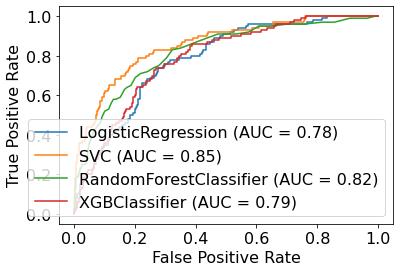

In [295]:
disp = plot_roc_curve(lr, X_test, y_test)
plot_roc_curve(svm, X_test, y_test, ax=disp.ax_)
plot_roc_curve(rf, X_test, y_test, ax=disp.ax_)
plot_roc_curve(xgb_m, X_test, y_test, ax=disp.ax_)

In [296]:
#table construction
accuracy = []
acc_lr = accuracy_score(y_test, lr.predict(X_test))
accuracy.append(acc_lr)
acc_svm = accuracy_score(y_test, svm.predict(X_test))
accuracy.append(acc_svm)
acc_rf = accuracy_score(y_test, rf.predict(X_test))
accuracy.append(acc_rf)
acc_xgb = accuracy_score(y_test, xgb_m.predict(X_test))
accuracy.append(acc_xgb)

precision = []
prec_lr = precision_score(y_test, lr.predict(X_test))
precision.append(prec_lr)
prec_svm = precision_score(y_test, svm.predict(X_test))
precision.append(prec_svm)
prec_rf = precision_score(y_test, rf.predict(X_test))
precision.append(prec_rf)
prec_xgb = precision_score(y_test, xgb_m.predict(X_test))
precision.append(prec_xgb)

recall = []
rec_lr = recall_score(y_test, lr.predict(X_test))
recall.append(rec_lr)
rec_svm = recall_score(y_test, svm.predict(X_test))
recall.append(rec_svm)
rec_rf = recall_score(y_test, rf.predict(X_test))
recall.append(rec_rf)
rec_xgb = recall_score(y_test, xgb_m.predict(X_test))
recall.append(rec_xgb)

f1 = []
f1_lr = f1_score(y_test, lr.predict(X_test))
f1.append(f1_lr)
f1_svm = f1_score(y_test, svm.predict(X_test))
f1.append(f1_svm)
f1_rf = f1_score(y_test, rf.predict(X_test))
f1.append(f1_rf)
f1_xgb = f1_score(y_test, xgb_m.predict(X_test))
f1.append(f1_xgb)

roc_auc = []
roc_auc_lr = roc_auc_score(y_test, lr.decision_function(X_test))
roc_auc.append(roc_auc_lr)
roc_auc_svm = roc_auc_score(y_test, svm.decision_function(X_test))
roc_auc.append(roc_auc_svm)
roc_auc_rf = roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])
roc_auc.append(roc_auc_rf)
roc_auc_xgb = roc_auc_score(y_test, xgb_m.predict_proba(X_test)[:,1])
roc_auc.append(roc_auc_xgb)

models = ['logistic_regression', 'support_vector_machines', 'random_forest', 'xgboost']

In [297]:
results = pd.DataFrame({'model': models,
                       'accuracy': accuracy,
                       'precision': precision,
                       'recall': recall,
                       'f1': f1,
                       'roc_auc': roc_auc})

In [298]:
# %%notify
results

,model,accuracy,precision,recall,f1,roc_auc
0,logistic_regression,0.881200,0.440000,0.11,0.176000,0.781095
1,support_vector_machines,0.897347,0.587302,0.37,0.453988,0.854694
2,random_forest,0.890427,0.777778,0.07,0.128440,0.818396
3,xgboost,0.863899,0.344828,0.20,0.253165,0.785776


In [159]:
# results.to_csv('model_df_rob1_results.csv')
# results.to_csv('model_hc_rob1_results.csv')
# results.to_csv('model_bf_rob1_results.csv')
# results.to_csv('model_bf_hc_rob1_results.csv')
# results.to_csv('model_bf_facets_rob1_results.csv')
# results.to_csv('model_bf_facets_hc_rob1_results.csv')

In [160]:
# results.to_csv('model_df_rob2_results.csv')
# results.to_csv('model_hc_rob2_results.csv')
# results.to_csv('model_bf_rob2_results.csv')
# results.to_csv('model_bf_hc_rob2_results.csv')
# results.to_csv('model_bf_facets_rob2_results.csv')
# results.to_csv('model_bf_facets_hc_rob2_results.csv')

In [161]:
# results.to_csv('model_df_rob3_results.csv')
# results.to_csv('model_hc_rob3_results.csv')
# results.to_csv('model_bf_rob3_results.csv')
# results.to_csv('model_bf_hc_rob3_results.csv')
# results.to_csv('model_bf_facets_rob3_results.csv')
results.to_csv('model_bf_facets_hc_rob3_results.csv')

In [27]:
joblib.dump(rf, "./random_forest.joblib")
# joblib.dump(xgb, "./xgb.joblib")
joblib.dump(svm, "./svm.joblib")
joblib.dump(lr, "./lr.joblib")

In [4]:
loaded_rf = joblib.load("./random_forest.joblib")
svm = joblib.load("./svm.joblib")

In [24]:
rf.score(X_test,y_test)==loaded_rf.score(X_test,y_test)

True

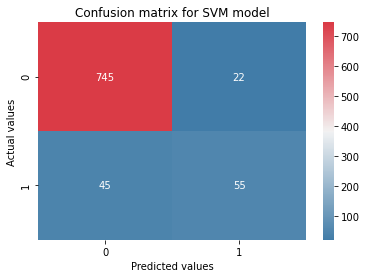

In [75]:
ax = plt.axes()

cf_matrix = confusion_matrix(y_test, svm.predict(X_test))

cmap = sns.diverging_palette(240, 10, n=100, as_cmap=True)

# sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, annot_kws={"size": 10},fmt=".2%", cmap=cmap)
sns.heatmap(cf_matrix, annot=True, annot_kws={"size": 10},fmt="d", cmap=cmap, ax=ax)
#ax.set_title('Confusion matrix SVM model')

ax.set_title('Confusion matrix for SVM model')
ax.set_xlabel('Predicted values')
ax.set_ylabel('Actual values')
plt.show()

### Feature importance 

In [ ]:
#note: for SVC without a linear kernel, feature importance cannot be determined and for random forests, only the magnitude of the features can be determined, not the direction (pos or neg)

In [546]:
explainer = shap.TreeExplainer(rf, check_additivity=False)

choosen_instance = X_test.loc[[529]]
shap_values_1 = explainer.shap_values(choosen_instance, check_additivity=False)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values_1[1], choosen_instance)

In [126]:
print((len(test)-len(test[test['test']==0]))/len(test))
# y_test.loc[[3336]]

0.11534025374855825


In [27]:
# shap_values_1[1]
explainer.expected_value[1]

0.1182216708023159

In [ ]:
# rf_shap_values = shap.KernelExplainer(rf.predict,X_test)
# shap.summary_plot(rf_shap_values, X_test)

In [ ]:
#didn't work

# import shap
# shap.initjs()
# # compute SHAP values
# explainer = shap.Explainer(loaded_rf, X_train, check_additivity=False)
# shap_values = explainer(X_train, check_additivity=False)
# # summary_plot
# shap.plots.beeswarm(shap_values)

In [ ]:
# shap_values = shap.TreeExplainer(rf, check_additivity=False).shap_values(X_test, check_additivity=False)
# shap.summary_plot(shap_values, X_test, plot_type="bar")

invalid value encountered in true_divide
invalid value encountered in true_divide


Text(0.5, 1.0, 'Feature importance random forest model')

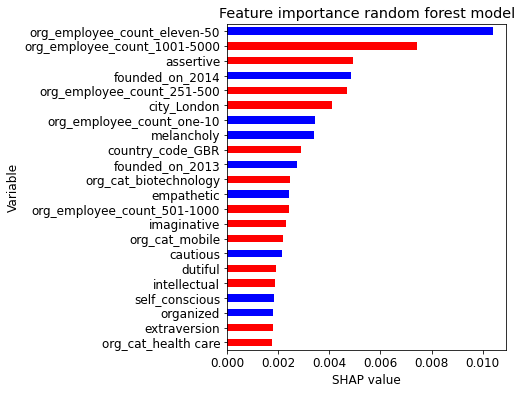

In [212]:
# shap_values = shap.TreeExplainer(rf, check_additivity=False).shap_values(X_test, check_additivity=False)

shap_v = pd.DataFrame(shap_values[1])
feature_list = X_test.columns
shap_v.columns = feature_list
df_v = X_test.copy().reset_index().drop('index',axis=1)

# Determine the correlation in order to plot with different colors
corr_list = list()
for i in feature_list:
    b = np.corrcoef(shap_v[i],df_v[i])[1][0]
    corr_list.append(b)
corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
# Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
corr_df.columns  = ['Variable','Corr']
corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')

# Plot it
shap_abs = np.abs(shap_v)
k=pd.DataFrame(shap_abs.mean()).reset_index()
k.columns = ['Variable','SHAP_abs']
k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
k2 = k2.sort_values(by='SHAP_abs',ascending = False).head(n=22).sort_values(by='SHAP_abs',ascending = True) #k2.sort_values(by='SHAP_abs',ascending = True)
colorlist = k2['Sign']
ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
ax.set_xlabel("SHAP value")
ax.set_title("Feature importance random forest model")

Text(0.5, 1.0, 'Feature importance random forest model')

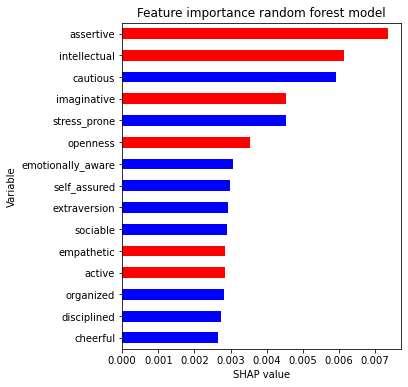

In [128]:
filter_list = ['active','adventurous', 'aggressive', 
                         'agreeableness', 'ambitious','anxiety_prone',
                         'artistic', 'assertive', 'cautious', 'cheerful',
                         'conscientiousness', 'cooperative', 'disciplined',
                         'dutiful','emotionally_aware', 'empathetic', 'energetic',
                         'extraversion','friendly', 'generous', 'genuine',
                         'humble', 'imaginative', 'impulsive','intellectual',
                         'liberal', 'melancholy', 'neuroticism', 'openness',
                         'organized', 'self_assured', 'self_conscious',
                         'sociable','stress_prone', 'trusting']
k3 = k2[k2.Variable.isin(filter_list)]
k3 = k3.sort_values(by='SHAP_abs',ascending = False).sort_values(by='SHAP_abs',ascending = True) #k2.sort_values(by='SHAP_abs',ascending = True)
colorlist = k3['Sign']
ax = k3.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
ax.set_xlabel("SHAP value")
ax.set_title("Feature importance random forest model")

In [129]:
k2[k2.Variable.isin(filter_list)]

,Variable,SHAP_abs,Corr,Sign
58,cheerful,0.002660,-0.567738,blue
61,disciplined,0.002742,-0.489473,blue
78,organized,0.002831,-0.508458,blue
49,active,0.002850,0.567507,red
64,empathetic,0.002856,0.599625,red
81,sociable,0.002903,-0.585282,blue
66,extraversion,0.002941,-0.355982,blue
79,self_assured,0.002976,-0.374636,blue
63,emotionally_aware,0.003075,-0.011770,blue
77,openness,0.003551,0.563139,red


In [131]:
k2.Variable.to_list()

['org_cat_apps',
 'org_employee_count_251-500',
 'cheerful',
 'org_employee_count_501-1000',
 'disciplined',
 'organized',
 'active',
 'empathetic',
 'sociable',
 'extraversion',
 'self_assured',
 'emotionally_aware',
 'openness',
 'stress_prone',
 'imaginative',
 'cautious',
 'intellectual',
 'org_employee_count_eleven-50',
 'assertive',
 'org_cat_biotechnology',
 'org_num_funding_rounds',
 'raised_amount_usd']

In [31]:
shap_v = pd.DataFrame(shap_values[1])

shap_v

,0,1,2,3,4,5,6,7,8,9,...,979,980,981,982,983,984,985,986,987,988
0,0.027404,-0.003754,0.000085,-0.000507,-0.001282,-0.001494,-0.000582,0.004484,-0.001110,-0.000838,...,-0.001188,-0.005214,0.001294,0.038395,-0.001008,-0.002184,0.000747,0.005404,0.002768,0.000011
1,-0.017502,-0.003062,-0.000357,0.001023,-0.000124,-0.000321,-0.000038,-0.000082,0.000420,0.004446,...,-0.000863,-0.005167,0.000668,-0.003706,-0.000752,-0.003073,0.000334,-0.014770,0.002645,-0.000002
2,-0.013888,-0.002176,-0.000846,0.002842,0.010751,-0.000442,-0.000164,0.000270,0.000113,-0.000528,...,-0.000930,-0.005648,0.000333,-0.002450,-0.000728,-0.004171,0.000270,-0.012186,0.002298,-0.000021
3,-0.027731,-0.005697,-0.000126,-0.001020,-0.000950,-0.000062,-0.000062,-0.000345,0.000390,-0.000240,...,-0.001042,-0.004252,-0.001373,-0.005226,-0.000735,-0.002119,-0.001545,0.008348,-0.024343,0.000056
4,-0.012956,-0.001052,-0.000525,-0.001113,-0.002277,-0.000890,-0.000062,-0.000014,0.000559,-0.000215,...,-0.001017,-0.004028,0.000469,-0.004412,-0.000668,-0.002725,0.000620,-0.010070,0.002882,0.000017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862,-0.014099,-0.000889,-0.000596,0.003955,-0.002489,-0.000796,-0.000265,-0.000596,-0.000859,-0.000377,...,-0.000998,-0.006532,0.000034,-0.002440,-0.000839,-0.003787,-0.000456,0.005992,-0.014965,-0.000071
863,0.131348,0.000159,0.000076,0.002740,-0.001002,0.000041,-0.000093,0.001411,0.001538,-0.000357,...,-0.000803,-0.005060,0.005348,0.073058,-0.001087,-0.002032,0.003856,0.017208,0.006096,0.000082
864,0.166375,0.091741,0.000369,0.016000,0.041253,-0.000186,0.000543,0.016154,0.004658,-0.000240,...,-0.000874,-0.005248,0.012510,0.002259,-0.000986,0.003084,0.003870,0.025257,0.007275,0.000023
865,-0.018355,0.001223,-0.000570,0.001616,-0.002808,-0.000613,-0.000263,0.000994,-0.000041,-0.000299,...,-0.000961,-0.005691,0.000064,-0.002512,-0.000735,-0.003437,-0.001455,-0.010656,0.001801,-0.000043
